In [ ]:
from pto.problems.as_classes import (
    OneMax, Sphere, HelloWorld,
    TSP, SymbolicRegression, GrammaticalEvolution, NeuralNetwork,
)
from pto import run, rnd

# needed for reading in the traces
from pto.core.fine_distributions import Random_real, Random_cat, Random_int
from random import random, choice, randint, randrange, uniform, seed

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import math

import time

In [2]:
solvers = [
    "random_search",
    "hill_climber",
    "genetic_algorithm",
    "particle_swarm_optimisation"
]

def solvers_argss(solver, budget):
    d = {
        "random_search": 
        {'n_generation': budget},
        "hill_climber": 
        {'n_generation': budget},
        "genetic_algorithm": 
        {'n_generation': int(math.sqrt(budget)), 
         'population_size': int(budget / int(math.sqrt(budget)))},
        "particle_swarm_optimisation": 
        {'n_iteration': int(math.sqrt(budget) / 4), 
         'n_particles': int(budget / (math.sqrt(budget) / 4))}
    }
    result = d[solver]
    result['return_history'] = True
    return result

In [ ]:
problems_sizess_budgetss_ctors = eval(open("budgets_2024_11_15.py").read())

In [ ]:
n_reps = 20
results = []

for rep in range(n_reps):
    for problem_name, size, budget, size_cat, ctor in problems_sizess_budgetss_ctors:    
        for size, budget, size_cat in zip(sizes, budgets, ["small", "medium", "large"]):
            print(problem_name, size, budget)
            problem = ctor(size)

            # this code could be used in future for estimation of effective dimensionality
            # opt_trace = problem_sizes_opt_traces[problem_name][size]
            # dim, budget = problem.estimate_effective_dimensionality_and_budget(opt_trace)
            # print(problem_name, size, dim, budget) 
            
            for solver in solvers:
                solver_args = solvers_argss(solver, budget)
                for dist_type in ['coarse', 'fine']:
                    for name_type in ['lin', 'str']:

                        seed(rep) # random.seed(rep)
                        start_time = time.time()
                        (pheno, geno), fx, history = run(problem.generator, 
                                            problem.fitness, 
                                            gen_args=problem.gen_args, 
                                            fit_args=problem.fit_args,
                                            Solver=solver,
                                            solver_args=solver_args,
                                            better=problem.better,
                                            dist_type=dist_type,
                                            name_type=name_type)
                        end_time = time.time()
                        elapsed = end_time - start_time
                        norm_fx = problem.normalise_fitness(fx)

                        filename = f'outputs/history_{problem.__class__.__name__} {size} {size_cat} {solver} {budget} {dist_type} {name_type} {rep}'.replace(' ', '_')
                        history_df = pd.DataFrame(history, columns=['fitness'])
                        history_df.to_csv(filename)

                        # we're not printing or saving gen_args - maybe we should? but they are large matrices, not just keywords
                        print(f'{problem.__class__.__name__} {size} {size_cat} {solver} {budget} {dist_type} {name_type} {rep} {elapsed} {fx} {norm_fx} "{pheno}" "{geno}"')
                        results.append((problem.__class__.__name__, size, size_cat, solver, budget, dist_type, name_type, rep, elapsed, fx, norm_fx, str(pheno), str(geno)))

columns = "problem size size_cat solver budget dist_type name_type rep elapsed fx norm_fx pheno geno".split(" ")
df = pd.DataFrame.from_records(columns=columns, data=results)
df.to_csv('outputs/results_2024_11_15.csv')

In [ ]:
df_main = pd.read_csv('outputs/results_main_2024_11_15.csv', index_col=0)

df_pso = pd.read_csv("outputs/results_pso_mut_123_2024_11_13.csv", index_col=0)

In [ ]:
df_main.shape, df_pso.shape

((6720, 14), (5040, 14), (640, 13))

In [99]:
len(df_main) == 7 * 3 * 4 * 2 * 2 * 20 # 7 problems, 3 sizes, 4 solvers, 2 dist_types, 2 name_types, 20 reps

True

In [ ]:
len(df_pso) == 7 * 3 * 1 * 2 * 2 * 3 * 20 # 7 problems, 3 sizes, 1 solvers, 2 dist_types, 2 name_types, 3 mutation values, 20 reps

True

In [ ]:
df_main['problem'].unique(), df_pso['problem'].unique()

(array(['OneMax', 'StringM', 'Sphere', 'TSP', 'BFS', 'GE', 'NN'],
       dtype=object),
 array(['OneMax', 'StringM', 'Sphere', 'TSP', 'BFS', 'GE', 'NN'],
       dtype=object),
 array(['TSP', 'BFS'], dtype=object))

In [ ]:
df_main['size_cat'].unique(), df_pso['size_cat'].unique()

(array(['S', 'M', 'L'], dtype=object),
 array(['S', 'M', 'L'], dtype=object),
 array(['L'], dtype=object))

In [ ]:
for problem in ['OneMax', 'TSP', 'BFS']:
    for size_cat in 'SML':
        print(df_main[(df_main['size_cat'] == size_cat) & (df_main['problem'] == problem)].shape)

(320, 14)
(320, 14)
(320, 14)
(320, 14)
(320, 14)
(320, 14)
(320, 14)
(320, 14)
(320, 14)


In [ ]:
def rename_problems_solvers_size_cats(df):

    renames = {
        'HelloWorld': 'StringM',
        'SymbolicRegression': 'BFS',
        'GrammaticalEvolution': 'GE',
        'NeuralNetwork': 'NN'
    }

    for k in renames:
        df['problem'] = df['problem'].str.replace(k, renames[k])

    renames = {
        'particle_swarm_optimisation': 'PS',
        'random_search': 'RS',
        'genetic_algorithm': 'GA',
        'hill_climber': 'HC',
    }

    for k in renames:
        df['solver'] = df['solver'].str.replace(k, renames[k])

    renames = {
        'small': 'S',
        'medium': 'M',
        'large': 'L'
    }

    for k in renames:
        df['size_cat'] = df['size_cat'].str.replace(k, renames[k])
    return df

df_main = rename_problems_solvers_size_cats(df_main)
df_pso = rename_problems_solvers_size_cats(df_pso)

In [ ]:
def create_problem_crosstab(problem_size_df, index): # by Claude. create a cross-tab with mean(+/- sd) for each problem instance

    # Create a multi-index column for (dist_type, name_type)
    problem_size_df['config'] = problem_size_df.apply(
        lambda row: f"{row['dist_type']}_{row['name_type']}", axis=1)
    
    # Create the cross-tabs for mean and std
    mean_tab = pd.pivot_table(problem_size_df, values='norm_fx', index=index, 
                            columns='config', aggfunc='mean')
    std_tab = pd.pivot_table(problem_size_df, values='norm_fx', index=index, 
                            columns='config', aggfunc='std')
    
    # Combine mean and std into a single table with formatted strings
    ctab = pd.DataFrame(index=mean_tab.index, columns=mean_tab.columns)
    for col in mean_tab.columns:
        for idx in mean_tab.index:
            mean_val = mean_tab.loc[idx, col]
            std_val = std_tab.loc[idx, col]
            ctab.loc[idx, col] = f"{mean_val:.2f} (±{std_val:.2f})"
    
    # Calculate row means and stds
    row_means = mean_tab.mean(axis=1)
    row_stds = mean_tab.std(axis=1)
    ctab['Mean'] = [f"{m:.2f} (±{s:.2f})" for m, s in zip(row_means, row_stds)]
    
    # Calculate column means and stds (including the Mean column)
    mean_with_summary = pd.concat([mean_tab, row_means.rename('Mean')], axis=1)
    std_with_summary = pd.concat([std_tab, row_stds.rename('Mean')], axis=1)
    
    # Create the Mean row with all columns (including Mean column)
    mean_row = [f"{m:.2f} (±{s:.2f})" for m, s in 
                zip(mean_with_summary.mean(), mean_with_summary.std())]
    
    ctab.loc['Mean'] = mean_row
    
    return ctab

# First group by problem and size, then create cross-tabs for each combination
grouped = df_main.groupby(['problem', 'size_cat'])

# Create and print cross-tabs for each problem and size
for (problem, size_cat), group in grouped:
    print(f"\n{problem} - Size: {size}\n")
    ctab = create_problem_crosstab(group, 'solver')
    print(ctab)
    print("\n" + "="*50)  # Separator between problems

    ctab.to_latex(f'outputs/results_crosstab_main_{problem}_{size_cat}.tex')

with open('outputs/results_crosstab_tmp.txt', 'w') as f:
    for (problem, size), group in grouped:
        f.write(f"\n{problem} - Size: {size}\n")
        ctab = create_problem_crosstab(group, 'solver')
        f.write(ctab.to_string())
        f.write("\n\n" + "="*50 + "\n")

# First group by problem and size, then create cross-tabs for each combination
grouped = df_pso.groupby(['problem', 'size_cat'])

# Create and print cross-tabs for each problem and size
for (problem, size_cat), group in grouped:
    print(f"\n{problem} - Size: {size}\n")
    ctab = create_problem_crosstab(group, 'mut')
    print(ctab)
    print("\n" + "="*50)  # Separator between problems

    ctab.to_latex(f'outputs/results_crosstab_pso_{problem}_{size_cat}.tex')

with open('outputs/results_crosstab_tmp_pso.txt', 'w') as f:
    for (problem, size), group in grouped:
        f.write(f"\n{problem} - Size: {size}\n")
        ctab = create_problem_crosstab(group, 'mut')
        f.write(ctab.to_string())
        f.write("\n\n" + "="*50 + "\n")


GrammaticalEvolution - Size: small

config    coarse_lin    coarse_str      fine_lin      fine_str          Mean
solver                                                                      
GA      0.66 (±0.18)  0.75 (±0.14)  0.65 (±0.19)  0.75 (±0.14)  0.70 (±0.05)
HC      0.68 (±0.18)  0.77 (±0.17)  0.71 (±0.18)  0.77 (±0.17)  0.73 (±0.04)
PS      0.67 (±0.17)  0.74 (±0.14)  0.68 (±0.17)  0.75 (±0.15)  0.71 (±0.04)
RS      0.53 (±0.23)  0.53 (±0.23)  0.53 (±0.23)  0.53 (±0.23)  0.53 (±0.00)
Mean    0.64 (±0.07)  0.70 (±0.11)  0.64 (±0.08)  0.70 (±0.11)  0.67 (±0.09)


GrammaticalEvolution - Size: small

config    coarse_lin    coarse_str      fine_lin      fine_str          Mean
solver                                                                      
GA      0.90 (±0.11)  0.93 (±0.07)  0.88 (±0.13)  0.93 (±0.07)  0.91 (±0.02)
HC      0.92 (±0.09)  0.94 (±0.06)  0.92 (±0.08)  0.94 (±0.06)  0.93 (±0.01)
PS      0.92 (±0.08)  0.93 (±0.08)  0.93 (±0.08)  0.93 (±0.08)  0.93 (±0.01)
R

In [ ]:
# by Claude.
def plot_experiment_results(df, output_dir=None):
    # Get unique problems
    problems = df['problem'].unique()
    
    # Set the style
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    
    for problem in problems:
        # Create a copy of the filtered data
        problem_df = df[df['problem'] == problem].copy()
        
        # Create ordered categorical variables first
        #size_order = ['small', 'medium', 'large']
        #problem_df['size_cat'] = pd.Categorical(problem_df['size_cat'], categories=size_order, ordered=True)

        # Then create groups in desired order
        problem_df['group'] = (problem_df['size_cat']        + '_' + 
                               problem_df['mut'].astype(str) + '_' + 
                               problem_df['dist_type']       + '_' + 
                               problem_df['name_type']              )
                            
        # Create the ordered list of all possible combinations
        group_order = []
        for size in ['small', 'medium', 'large']:
            for m in ['1', '2', '3']:
                for dist in ['coarse', 'fine']:
                    for name in ['lin', 'str']:            
                        group_order.append(f"{size}_{m}_{dist}_{name}")

        # Create figure with appropriate size
        plt.figure(figsize=(15, 8))
        
        # Create the strip plot for individual points
        sns.stripplot(data=problem_df, x='group', y='norm_fx', 
                     size=4, alpha=0.3, jitter=0.2, color='blue',
                     order=group_order)
        
        # Add mean points
        sns.pointplot(data=problem_df, x='group', y='norm_fx',
                     color='red', scale=0.7, markers='D',
                     order=group_order)
        
        # Customize the plot
        plt.title(f'Results for {problem}', pad=20, size=14)
        plt.xlabel('Configuration (size_mutation_distribution_naming)', size=12)
        plt.ylabel('Normalized Fitness', size=12)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        # Save the plot if output directory is provided
        if output_dir:
            plt.savefig(f'{output_dir}/{problem}_results.png', 
                       bbox_inches='tight')
        
        plt.close()

In [ ]:
# Example usage:
plot_experiment_results(df, output_dir='outputs/')

/var/folders/yg/h7gctm5d43q02026dgq6w0wh0000gn/T/ipykernel_19703/2576691205.py:45: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=problem_df, x='group', y='norm_fx',
/var/folders/yg/h7gctm5d43q02026dgq6w0wh0000gn/T/ipykernel_19703/2576691205.py:45: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=problem_df, x='group', y='norm_fx',
/var/folders/yg/h7gctm5d43q02026dgq6w0wh0000gn/T/ipykernel_19703/2576691205.py:45: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

 

In [ ]:
# Define the order for problems and solvers
problem_order = ['OneMax', 'StringM', 'Sphere', 'TSP', 
                'BFS', 'GE', 
                'NN']

solver_order = ['RS', 'HC', 'GA', 'PS']

size_order = 'SML'

group_order = [
    'lin - coarse',
    'lin - fine',
    'str - coarse',
    'str - fine'
]

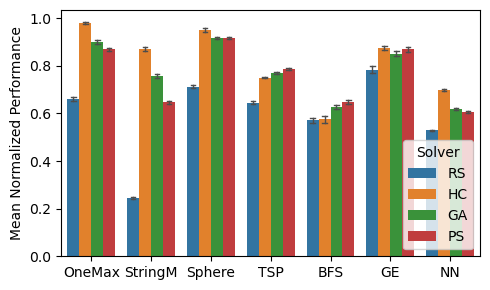

In [ ]:
# Calculate mean and standard error for each problem-solver combination
performance_summary = (df_main.groupby(['problem', 'solver'])['norm_fx']
                     .agg(['mean', 'std', 'count'])
                     .reset_index())
performance_summary.columns = ['problem', 'solver', 'mean', 'lower', 'upper']

# Calculate standard error
# performance_summary['stderr'] = (performance_summary['std'] / 
#                                np.sqrt(performance_summary['count']))

# Create the plot
plt.figure(figsize=(5, 3))
sns.barplot(data=df_main,
            x='problem',
            y='norm_fx',
            hue='solver',
            order=problem_order,
            hue_order=solver_order,
            errorbar='se',
            err_kws={"color": "0.3", "linewidth": 1.},
            capsize=0.3
            )  

# Customize the plot
# plt.title('Mean Performance by Problem and Solver', pad=20)
plt.xlabel('')
plt.ylabel('Mean Normalized Performance')

# Rotate x-axis labels
#plt.xticks(rotation=45, ha='right')

# Add legend inside the plot
plt.legend(title='Solver', loc='lower right')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('outputs/problems_v_solvers_mean_se.pdf')

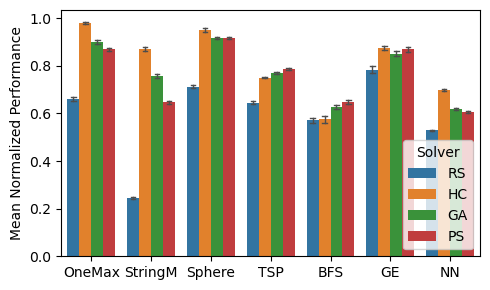

In [ ]:
# Create the plot
plt.figure(figsize=(5, 3))
sns.barplot(data=df_main,
            x='problem',
            y='norm_fx',
            hue='solver',
            order=problem_order,
            hue_order=solver_order,
            errorbar='se',
            err_kws={"color": "0.3", "linewidth": 1.},
            capsize=0.3
            )  

# Customize the plot
# plt.title('Mean Performance by Problem and Solver', pad=20)
plt.xlabel('')
plt.ylabel('Mean Normalized Performance')

# Rotate x-axis labels
#plt.xticks(rotation=45, ha='right')

# Add legend inside the plot
plt.legend(title='Solver', loc='lower right')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('outputs/problems_v_solvers_large_mean_se.pdf')

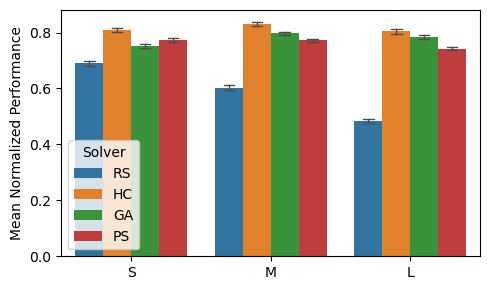

In [ ]:
# Create the plot
plt.figure(figsize=(5, 3))
sns.barplot(data=df_main,
            x='size_cat',
            y='norm_fx',
            hue='solver',
            order=size_order,
            hue_order=solver_order,
            errorbar='se',
            err_kws={"color": "0.3", "linewidth": 1.},
            capsize=0.3
            )  # Use standard error for error bars

# Customize the plot
# plt.title('Mean Performance by Problem and Solver', pad=20)
plt.xlabel('')
plt.ylabel('Mean Normalized Performance')

# Rotate x-axis labels
#plt.xticks(rotation=45, ha='right')

# Add legend inside the plot
plt.legend(title='Solver', loc='lower left')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('outputs/sizes_v_solvers_mean_se.pdf')

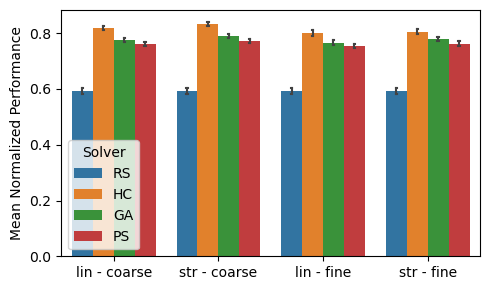

In [ ]:
# # Create a combined category for x-axis
# df_main_new['name_dist'] = (df_main_new['name_type'] + ' - ' + 
#                               df_main_new['dist_type'])

# Create the plot
plt.figure(figsize=(5, 3))

# Create nested bars using name_type and dist_type as x-axis categories
sns.barplot(data=df_main,
            x='name_dist',
            y='norm_fx',
            hue='solver',
            errorbar='se',
            capsize=0.05,
            err_kws={'linewidth': 1.5},
            hue_order=solver_order,
            dodge=True)

# Customize the plot
#plt.title('Mean Performance by Name Type, Distribution Type, and Solver', pad=20)
plt.xlabel('')
plt.ylabel('Mean Normalized Performance')

# Add legend inside the plot
plt.legend(title='Solver', loc='lower left')

# Adjust layout
plt.tight_layout()
plt.savefig('outputs/names_dists_v_solvers_mean_se.pdf')

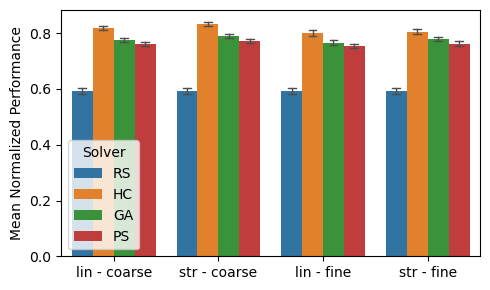

In [ ]:


# # Create a combined category for x-axis
# df_main_new['name_dist'] = (df_main_new['name_type'] + ' - ' + 
#                               df_main_new['dist_type'])

# Define orders
group_order = [
    'lin - coarse',
    'lin - fine',
    'str - coarse',
    'str - fine'
]
solver_order = ['RS', 'HC', 'GA', 'PS']

# Create the plot
plt.figure(figsize=(5, 3))

# Create nested bars using name_type and dist_type as x-axis categories
sns.barplot(data=df_main,
            x='name_dist',
            y='norm_fx',
            hue='solver',
            hue_order=solver_order,
            errorbar='se',
            err_kws={"color": "0.3", "linewidth": 1.},
            capsize=0.3
            #dodge=True
            )

# Customize the plot
#plt.title('Mean Performance by Name Type, Distribution Type, and Solver', pad=20)
plt.xlabel('')
plt.ylabel('Mean Normalized Performance')

# Add legend inside the plot
plt.legend(title='Solver', loc='lower left')

# Adjust layout
plt.tight_layout()
plt.savefig('outputs/names_dists_v_solvers_large_mean_se.pdf')

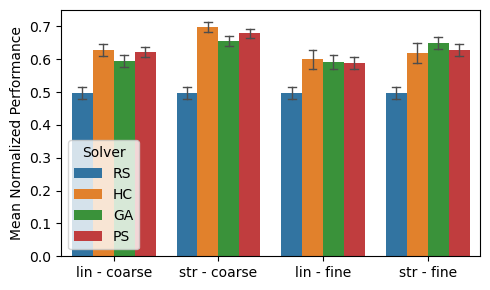

In [ ]:

# Define orders
group_order = [
    'lin - coarse',
    'lin - fine',
    'str - coarse',
    'str - fine'
]
solver_order = ['RS', 'HC', 'GA', 'PS']

# Create the plot
plt.figure(figsize=(5, 3))

# Create nested bars using name_type and dist_type as x-axis categories
sns.barplot(data=df_main[(df_main['size_cat'] == 'L') & (df_main['problem'].isin(['BFS', 'GE', 'NN']))],
            x='name_dist',
            y='norm_fx',
            hue='solver',
            hue_order=solver_order,
            errorbar='se',
            err_kws={"color": "0.3", "linewidth": 1.},
            capsize=0.3)

# Customize the plot
#plt.title('Mean Performance by Name Type, Distribution Type, and Solver', pad=20)
plt.xlabel('')
plt.ylabel('Mean Normalized Performance')

# Add legend inside the plot
plt.legend(title='Solver', loc='lower left')

# Adjust layout
plt.tight_layout()
plt.savefig('outputs/names_dists_v_solvers_large_nn_bfs_ge_mean_se.pdf')

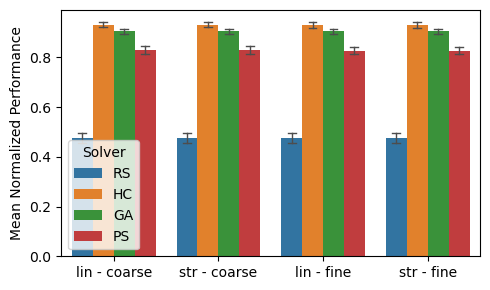

In [ ]:

# Create the plot
plt.figure(figsize=(5, 3))

# Create nested bars using name_type and dist_type as x-axis categories
sns.barplot(data=df_main[(df_main['size_cat'] == 'L') & (df_main['problem'].isin(['OneMax', 'StringM', 'Sphere', 'TSP']))],
            x='name_dist',
            y='norm_fx',
            hue='solver',
            hue_order=solver_order,
            errorbar='se',
            err_kws={"color": "0.3", "linewidth": 1.},
            capsize=0.3)

# Customize the plot
#plt.title('Mean Performance by Name Type, Distribution Type, and Solver', pad=20)
plt.xlabel('')
plt.ylabel('Mean Normalized Performance')

# Add legend inside the plot
plt.legend(title='Solver', loc='lower left')

# Adjust layout
plt.tight_layout()
plt.savefig('outputs/names_dists_v_solvers_large_onemax_stringm_sphere_tsp_mean_se.pdf')

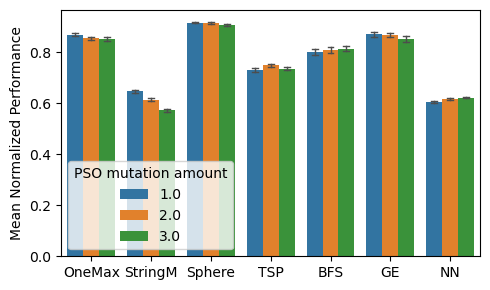

In [ ]:


# Create the plot
plt.figure(figsize=(5, 3))
sns.barplot(data=df_pso,
            x='problem',
            y='norm_fx',
            hue='mut',
            order=problem_order,
            # hue_order=solver_order,
            palette="tab10",
            errorbar='se',
            err_kws={"color": "0.3", "linewidth": 1.},
            capsize=0.3)

# Customize the plot
# plt.title('Mean Performance by Problem and Solver', pad=20)
plt.xlabel('')
plt.ylabel('Mean Normalized Performance')

# Rotate x-axis labels
#plt.xticks(rotation=45, ha='right')

# Add legend inside the plot
plt.legend(title='PSO mutation amount', loc='lower left')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('outputs/problems_v_pso_mut_mean_se.pdf')